In [2]:
import nidaqmx
import numpy as np
import windfreak
import ctypes
import nidaqmx._lib  # Due to NIDAQmx C-API bug needed to bypass property getter (according to qudi)
import nidaqmx.stream_readers
import time
import matplotlib.pyplot as plt

In [6]:
mw_source = None

In [4]:
low_f = 2820e6
high_f = 2920e6
# low_f = 10e6
# high_f = 20e6
n_steps = 101
scan_frequency_ranges = [low_f, high_f, n_steps] #change to start freq, stop freq and N step
scan_power = -10.0 #dBmW

data_rate = 200 #Hz
num_loops = 100

#sample_rate = oversampling_factor * data_rate

In [8]:
# devices
if mw_source is None:
    mw_source = windfreak.SynthHD('COM5')
mw_direct_device = mw_source 

In [63]:
mw_source.close()

In [64]:
del mw_source

In [9]:
mw_source[0].frequency

2820000000.0

In [10]:
# ni daq

device_name = 'Dev1'


In [11]:
device_handle = nidaqmx.system.Device(device_name)


In [12]:
device_handle.reset_device()


In [56]:
# trigger mode: single step
#mw_direct_device._write('w0')

In [119]:
#configure the RF scan
# configures the MW source

# qudi_odmr_logic calls mw.configure_scan(power, frequencies, mode, sample_rate),
#which then calls
# mw._write_sweep, which is reproduced here
#start, stop, points = self._scan_frequencies
#start, stop, points = frequencies

frequency_step = (high_f - low_f) / (n_steps - 1)

# sweep mode: linear sweep, non-continuous
# can later transform this into more readable windfreak calls
mw_direct_device._write('X0')
mw_direct_device._write('c0')

# trigger mode: single step
mw_direct_device._write('w2')

# sweep direction
if high_f >= low_f:
    mw_direct_device._write('^1')
else:
    mw_direct_device._write('^0')

# sweep lower and upper frequency and steps
mw_direct_device._write(f'l{low_f / 1e6:5.7f}')
mw_direct_device._write(f'u{high_f / 1e6:5.7f}')
mw_direct_device._write(f's{frequency_step / 1e6:5.7f}')

# set power
mw_direct_device._write(f'W{scan_power:2.3f}')
# set sweep lower end power
mw_direct_device._write(f'[{scan_power:2.3f}')
# set sweep upper end power
mw_direct_device._write(f']{scan_power:2.3f}')

#after _write_sweep, configure_sweep continues

#mw_direct_device._write(f't{1000 * 0.75 / data_rate:f}') #sweep time step in ms #what is this? why 0.75. data_rate = 200, this is 0.75 * 5ms = 3.75ms, which is actually OUT OF RANGE according to this documentation https://github.com/christian-hahn/windfreak-python/blob/master/windfreak/synth_hd.py#L365
#freq_step_time = 1000 #ms
freq_step_time = 1000 / data_rate
mw_direct_device._write(f't{freq_step_time:f}') #amount of time spent at each frequency step

time_per_frequency = float(mw_direct_device._query('t?'))
total_time_in_ms = time_per_frequency * (n_steps)

print(f'Configured scan with')
print( f'scan_power = {scan_power}')
print(f'scan_frequencies (low to high) = {low_f*1e-6} - {high_f*1e-6} MHz')
print(f'frequency step size = {frequency_step*1e-6} MHz')
print(f'time @ each frequency = {time_per_frequency} ms')
print(f'number of steps = {n_steps}')
print(f'time for full scan = {total_time_in_ms*1e-3} s')
                

Configured scan with
scan_power = -10.0
scan_frequencies (low to high) = 2820.0 - 2920.0 MHz
frequency step size = 1.0 MHz
time @ each frequency = 5.0 ms
number of steps = 101
time for full scan = 0.505 s


In [14]:
mw_direct_device._write('g1') #starts the scan over

In [15]:
mw_direct_device._write('E1r1h1') #on
#mw_direct_device._write('E0r0h0') #off

In [69]:
all_tasks = {}

In [126]:


def configure_tasks(post_fix_task_name = '13'):
    read_write_timeout = 10
    device_name = 'Dev1'
    clock_counter = 'ctr0'
    edge_input_channel = 'PFI0'
    edge_input_counter = 'ctr2'

    clock_task_name = f'sample_clock{post_fix_task_name}'
    if clock_task_name in all_tasks.keys():
        clock_task = all_tasks[clock_task_name]
    else:
        clock_task = nidaqmx.Task(clock_task_name)
        all_tasks[clock_task_name] = clock_task
   
    
        clock_task.co_channels.add_co_pulse_chan_freq(
                '/{0}/{1}'.format(device_name, clock_counter),
                freq=data_rate,
                idle_state=nidaqmx.constants.Level.LOW)

        clock_task.timing.cfg_implicit_timing(
            sample_mode=nidaqmx.constants.AcquisitionType.FINITE,
            samps_per_chan=n_steps+2) #qudi configures with n_steps + 1, should recheck why. suspicious extra "1" floating around (n_steps = 101)

    edge_detector_task_name = f'edge_input{post_fix_task_name}'
    if edge_detector_task_name in all_tasks.keys():
        edge_detector_task = all_tasks[edge_detector_task_name]
    else:        
        edge_detector_task = nidaqmx.Task(edge_detector_task_name)
        all_tasks[edge_detector_task_name] = edge_detector_task

        ctr_name = '/{0}/{1}'.format(device_name, edge_input_counter)
        edge_detector_task.ci_channels.add_ci_period_chan(
                            ctr_name,
                            min_val=0,
                            max_val=100000000,
                            units=nidaqmx.constants.TimeUnits.TICKS,
                            edge=nidaqmx.constants.Edge.RISING)

        # from qudi
        chnl_name = '/{0}/{1}'.format(device_name, edge_input_channel)
        clock_channel = '/{0}InternalOutput'.format(clock_task.channel_names[0])

        try:
            nidaqmx._lib.lib_importer.windll.DAQmxSetCIPeriodTerm(
                edge_detector_task._handle,
                ctypes.c_char_p(ctr_name.encode('ascii')),
                ctypes.c_char_p(clock_channel.encode('ascii')))
            nidaqmx._lib.lib_importer.windll.DAQmxSetCICtrTimebaseSrc(
                edge_detector_task._handle,
                ctypes.c_char_p(ctr_name.encode('ascii')),
                ctypes.c_char_p(chnl_name.encode('ascii')))
        except:
            print("exception using windll. using cdll")
            nidaqmx._lib.lib_importer.cdll.DAQmxSetCIPeriodTerm(
                edge_detector_task._handle,
                ctypes.c_char_p(ctr_name.encode('ascii')),
                ctypes.c_char_p(clock_channel.encode('ascii')))
            nidaqmx._lib.lib_importer.cdll.DAQmxSetCICtrTimebaseSrc(
                edge_detector_task._handle,
                ctypes.c_char_p(ctr_name.encode('ascii')),
                ctypes.c_char_p(chnl_name.encode('ascii')))

        edge_detector_task.timing.cfg_implicit_timing(
            sample_mode=nidaqmx.constants.AcquisitionType.FINITE,
            samps_per_chan=n_steps)

    edge_detector_reader = nidaqmx.stream_readers.CounterReader(edge_detector_task.in_stream)
    
    return clock_task, edge_detector_task, edge_detector_reader

In [199]:
#prepare
def run_once(pftn='13'):
    read_write_timeout = 10
    
    data_buffer = np.zeros(n_steps)
    clock_task, data_task, data_reader = configure_tasks(pftn)
    
    
    #start scan from beginning
    mw_direct_device._write('g1')
    #time.sleep(0.20) #I can cause a shift in the data that makes it appear that the RF resontant frequency is different from 2.87 GHz
    #time.sleep(0.505)
    try:
        
        #start tasks
        clock_task.start()
        #time.sleep(0.25) #can I affect the phase by delaying? # yes, this causes readout errors
        data_task.start()
    
        #how do I do this? I need to wait long enough for the card to take all of the samples
        #qudi seems to simply read as fast as it can and then fills the buffer incrementally.
        #this seems fancy, but may be programatically complicated
        #here, we simply wait for the full scan of the RF range and then wait 10% more time
   
        time.sleep(total_time_in_ms *1.1e-3)


        read_samples = data_reader.read_many_sample_double(
                        data_buffer,
                        number_of_samples_per_channel=n_steps,
                        timeout=read_write_timeout)

        assert read_samples == n_steps
        
        #we need an external clock that starts the RF and the tasks at the same time
        

    except Exception as e:
        print(e)
    
    finally:
        data_task.stop()
        #data_task.close()
        clock_task.stop()
        #clock_task.close()
    
    return data_buffer

In [169]:
# for k in all_tasks.keys():
#     try:
#         t = all_tasks[k]
#         t.close()
#     except Exception as e:
#         print(k)
#         print(e)
        

In [171]:
mw_direct_device._write('E0r0h0') #off

In [200]:
all_data = []
mw_direct_device._write('E1r1h1') #on
#mw_direct_device._write('E0r0h0') #off
for i in range(30):
    if i % 10 == 0:
        print(f'scan {i}')
    all_data.append(run_once())
    
mw_direct_device._write('E0r0h0') #off

all_npdata = np.array(all_data)


scan 0
scan 10
scan 20


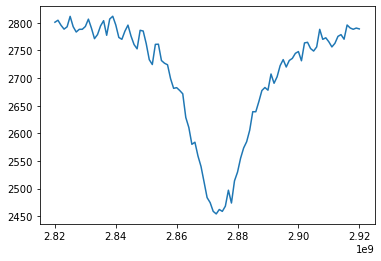

In [201]:
plt.plot(np.linspace(low_f, high_f, n_steps), all_npdata.mean(axis=0))


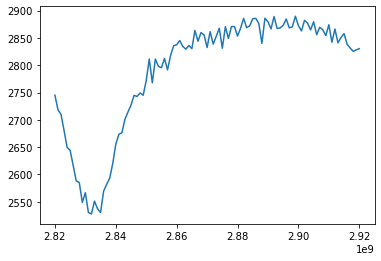

In [187]:
# we don't have a clock

#I can induce a phase-shift by adding a delay in the loop
# plt.plot(np.linspace(low_f, high_f, n_steps), all_npdata.mean(axis=0))
# time delay of 0.20 seconds

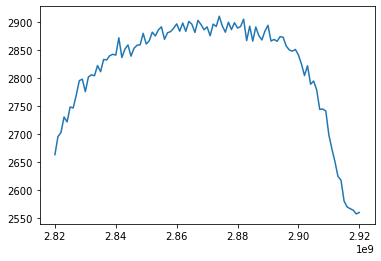

In [190]:
#I can induce a phase-shift by adding a delay in the loop
#plt.plot(np.linspace(low_f, high_f, n_steps), all_npdata.mean(axis=0))
# time delay of 0.30 seconds

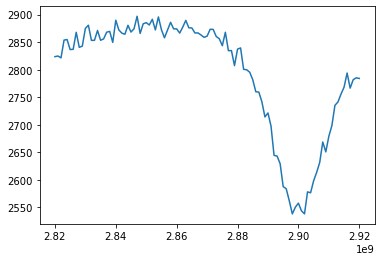

In [195]:
#I can induce a phase-shift by adding a delay in the loop
#plt.plot(np.linspace(low_f, high_f, n_steps), all_npdata.mean(axis=0))
# time delay of 0.40 seconds

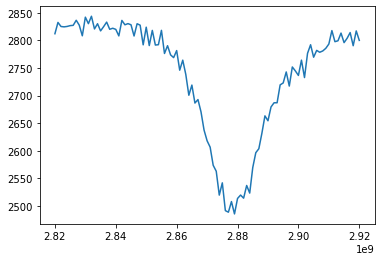

In [198]:
#I can induce a phase-shift by adding a delay in the loop
plt.plot(np.linspace(low_f, high_f, n_steps), all_npdata.mean(axis=0))
# time delay of 0.505 seonds -- which is the period of the scan across frequencies, resulting in an effective shift of ~0 GHz

In [ ]:
# but the point here is that we need a clock to tell when to start the various tasks

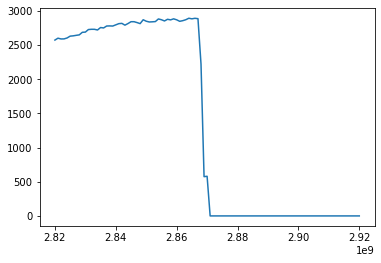

In [183]:

#I can cause a readout error by adding a delay between the start of the clock task and the start of the data read task
#you can see here that a delay of 0.25 seconds results in only half of the array being filled (the other half with zeros)
# plt.plot(np.linspace(low_f, high_f, n_steps), all_npdata.mean(axis=0))